In [4]:
# Load some basic libraries
%matplotlib inline
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from Gaia_Query_project import GaiaQuery


from sklearn.datasets import make_moons, fetch_openml
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.inspection import DecisionBoundaryDisplay  # Does not work on Google Collab
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from astropy.table import Table


In [ ]:
## Trainning 
# 1. Load data from FITS file


fits_path = "Final Project/GaiaData/TRAININGData_15kstars_15kgalaxies_15kquasars.fits"
data_training = Table.read(fits_path, format = "fits").to_pandas()

####################### Just to check
data_training = data_training.sample(n=20000, random_state=42)
##########################

# 2. Define features and label
features = ["parallax", "sinb", "pm", "uwe", "phot_g_mean_mag", "bp_g", "g_rp", "relvarg"]
X_training = data_training[features].values
y_training = data_training["classification"].values


## Small interlude to make y_train usable

# Decode bytes → str
y_training = np.array([label.decode() if isinstance(label, bytes) else label for label in y_training])
###### End of interlude

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_training, y_training, test_size=0.5, random_state=42, stratify=y_training
)


## Adaptive Boosting

In [ ]:
clf = AdaBoostClassifier(random_state=42)
clf.fit(X_train, y_train)



AdaBoostClassifier(random_state=42)

In [30]:
params = {"n_estimators": [50, 100, 200],
    "learning_rate": [ 0.1, 0.3, 0.5, 0.8, 1.0]}

search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=params,
    scoring='accuracy',  
    cv=5,  
    random_state=45311123,
    n_jobs=-1 )

search.fit(X_train, y_train)

model = search.best_estimator_

model


AdaBoostClassifier(learning_rate=0.3, n_estimators=200, random_state=42)

In [32]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["galaxy", "star","clusters"]))

print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

      galaxy       1.00      1.00      1.00      3286
        star       0.98      0.99      0.98      3350
    clusters       0.99      0.98      0.98      3364

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

[[3286    0    0]
 [   3 3300   47]
 [   3   61 3300]]


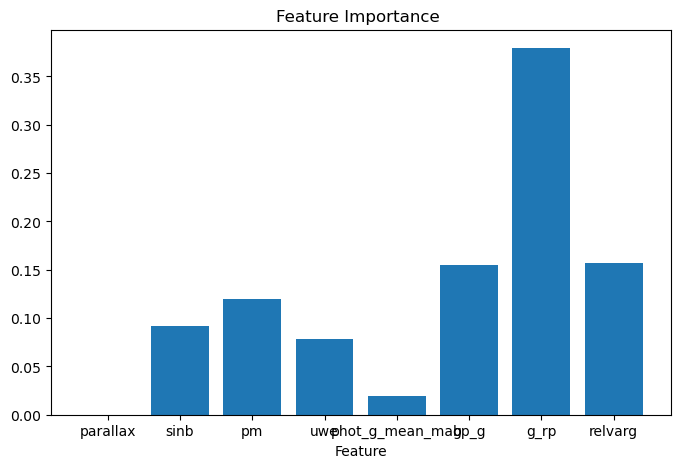

In [33]:
importances = clf.feature_importances_
plt.figure(figsize=(8, 5))
plt.bar(features, importances)
plt.xlabel("Feature")
plt.title("Feature Importance ")
plt.show()

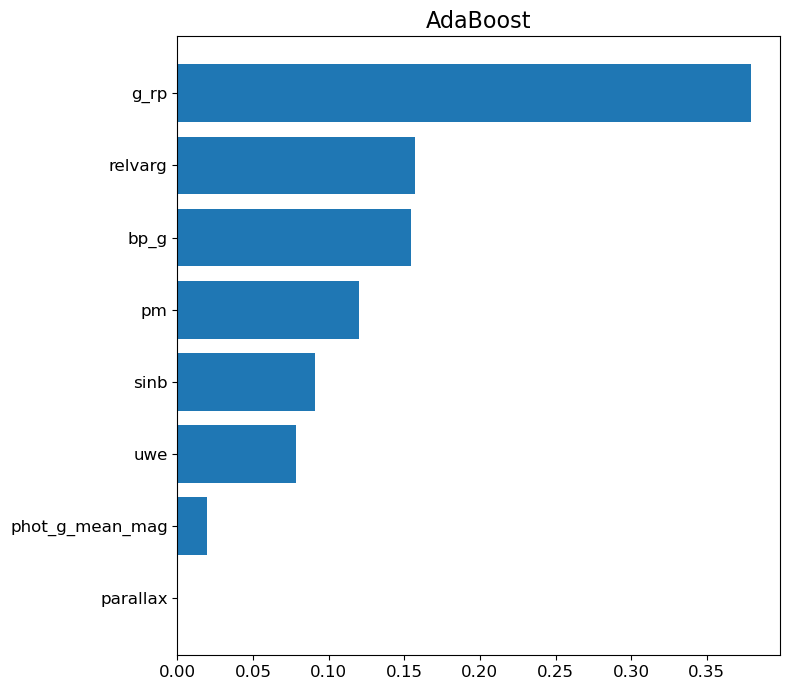

In [35]:
gini_importance = clf.feature_importances_
# perm_importance = some_other_importances_array  # Optional

# Sort by Gini importance
sorted_idx = np.argsort(gini_importance)[::-1]  # descending order

# Apply sorting to features and importances
sorted_features = np.array(features)[sorted_idx]
sorted_importances = gini_importance[sorted_idx]

# Normalize for coloring
normalized = (sorted_importances - np.min(sorted_importances)) / (np.max(sorted_importances) - np.min(sorted_importances))
cmap = plt.cm.coolwarm
colors = cmap(normalized)

# Plot
plt.figure(figsize=(8, 7))
plt.barh(sorted_features, sorted_importances)#, color=colors)
plt.title("AdaBoost", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()  # Flip to have most important at the top
plt.tight_layout()
plt.savefig("AdaBoostClassifier.png")
plt.show()
